### Import of required libraries

In [1]:
from traffic.core import Traffic
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
from tqdm.auto import tqdm
# import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
# import functions as fn
from traffic.data import nm_airspaces


In [ ]:
from airspace import airspace

as_switzerland = airspace(name = 'rectangle_Switzerland',
                          lat_min = 45.52084813133491,
                          lat_max = 47.85,
                          lon_min = 5.85392,
                          lon_max = 10.80539976710652,
                          alt_low = 18000,
                          alt_high = 60000,)

In [ ]:
as_switzerland.generate_grid()
as_switzerland.plot_grid()

In [ ]:
import math
import numpy as np

levels = np.array([*range(math.ceil((60000 - 18000)/3000))])
alts_low = 18000 + 3000 * levels
alts_high = 18000 + 3000 * (levels+1)
alts = np.array(list(zip(alts_low, alts_high)))
alts

In [ ]:
import functions as fn

lon_min = 5.85392
lon_max = 10.80539976710652
lat_min = 45.52084813133491
lat_max = 47.85

positions = [(lat_max, lon_min)]
lat = lat_max
lon = lon_min

while lat > lat_min:
    orig = (lat, lon)
    while lon < lon_max:
        lon = fn.new_pos_dist((lat, lon), 20, 90)[1]
        if lat>lat_min and lon<lon_max:
            positions.append((lat, lon))
    lat, lon = orig
    lat, lon = fn.new_pos_dist((lat, lon), 20, 180)


In [ ]:
len(positions)

In [ ]:
from airspace import cube

cube_1 = cube(positions[2], 1000, 20, 20)

In [ ]:
cube_1.get_edges()

In [ ]:
cube_1.get_vertices()

In [ ]:
cube_1.info()

### Preparation of data on trajectory level

In [3]:
trajs = Traffic.from_file('/cluster/home/krum/github/VT2_airspace_complexity/data/rectangle_Switzerland/03_preprocessed/preprocessed_all.parquet')

In [4]:
df = trajs.data
df = df.groupby('flight_id')['timestamp'].agg(['min', 'max']).reset_index()

In [5]:
df = df.rename({'min': 'in', 'max': 'out'}, axis=1)

In [6]:
df['stay_h'] = (df['out'] - df['in']).dt.total_seconds()/3600

In [7]:
df['timestamp_entered_h'] = df['in'].dt.floor('h')

In [8]:
df = df.drop(['in','out'], axis=1)

In [ ]:
# Load data, assign unique flight IDs, resample to 5s
trajs = Traffic.from_file('/cluster/home/krum/github/VT2_airspace_complexity/data/rectangle_Switzerland/03_preprocessed/preprocessed_2019_1.parquet')
# trajs_filt = trajs.assign_id().resample('5s').eval(desc='processing', max_workers=20)
# Aggregate by flight, determine stay time and hour of entry
df = trajs.data
df = df.groupby('flight_id')['timestamp'].agg(['min', 'max']).reset_index()
df = df.rename({'min': 'in', 'max': 'out'}, axis=1)
df['stay_h'] = (df['out'] - df['in']).dt.total_seconds()/3600
df['timestamp_entered_h'] = df['in'].dt.floor('h')
df = df.drop(['in','out'], axis=1)
df


### Group data by hour

In [10]:
# Aggregate by hour of entry, determine number of users and total stay time
hourly_stay = df.groupby(['timestamp_entered_h'])['stay_h'].sum()
hourly_users = df.groupby(['timestamp_entered_h'])['flight_id'].count()
hourly_df = pd.concat([hourly_users, hourly_stay], axis=1)#.reset_index()
hourly_df = hourly_df.rename({'flight_id': 'count'}, axis=1)
hourly_df


,count,stay_h
timestamp_entered_h,,
2019-01-01 00:00:00+00:00,5,1.061111
2019-01-01 01:00:00+00:00,2,0.719444
2019-01-01 02:00:00+00:00,5,1.658333
2019-01-01 03:00:00+00:00,12,4.569444
2019-01-01 04:00:00+00:00,28,7591.223611
...,...,...
2019-12-30 19:00:00+00:00,160,39.504167
2019-12-30 20:00:00+00:00,185,44.254167
2019-12-30 21:00:00+00:00,122,27.909722


ValueError: Could not interpret value `stay_s` for parameter `x`

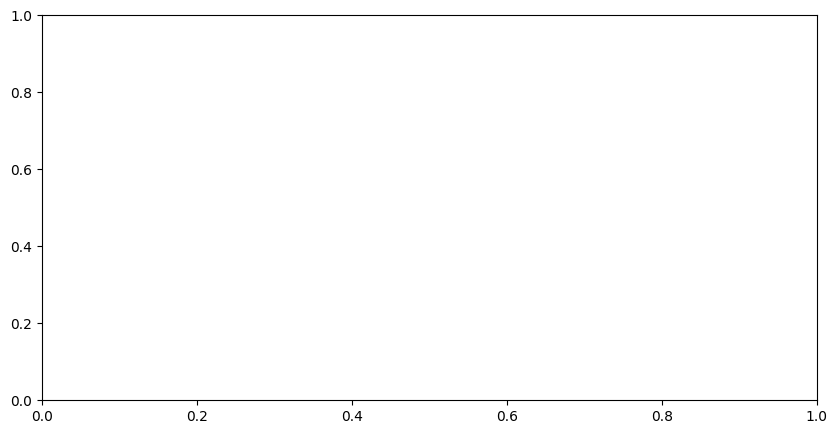

In [12]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(data=hourly_df, x='stay_s', ax=ax, bins=100)
ax.set_xlabel('Stay time [s]')
ax.set_ylabel('Number of flights')

In [ ]:
hourly_df['year'] = hourly_df.index.year
hourly_df = hourly_df[hourly_df['year'] == 2019]
hourly_df.reset_index(inplace=True)
hourly_df

In [ ]:
hourly_df['weekday'] = hourly_df['timestamp_entered_h'].dt.day_name()
# get average stay_s per weekday starting with Monday and plot
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(data=hourly_df, x='weekday', y='stay_s', ax=ax, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
ax.set_xlabel('Weekday')
ax.set_ylabel('Average stay time [s]')
ax.set_title('Average stay time per weekday')

In [ ]:
# multiple boxplot showing the distribution of stay_s per weekday, dont show outliers
ax = sns.boxplot(x="weekday", y="stay_s", data=hourly_df, showfliers=False)

In [ ]:
hourly_df['hour'] = hourly_df['timestamp_entered_h'].dt.hour
hourly_df.groupby('hour')['stay_s'].mean().plot()

In [ ]:
hourly_df['day'] = hourly_df['timestamp_entered_h'].dt.day
hourly_df.groupby('day')['stay_s'].median().plot()

In [ ]:
from prophet import Prophet

# create dataframe with timestamp and count
df = pd.DataFrame(hourly_df['stay_s'])
df = df.reset_index()
df = df.rename({'timestamp_entered_h': 'ds', 'stay_s': 'y'}, axis=1)
# remove timezone, set to utc
df['ds'] = df['ds'].dt.tz_localize(None)

m = Prophet()
m.add_country_holidays(country_name='CH')
m.fit(df)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)


In [ ]:
fig2 = m.plot_components(forecast)

In [ ]:
m.add_country_holidays(country_name='CH')

### Visualisation of data grouped by hour, day, week and month

In [ ]:
# Hour
hourly_group = hourly_df.groupby(pd.Grouper(freq='h')).sum()
hourly_group = hourly_group/hourly_group.quantile(0.99)
hourly_group.plot()

# Day
daily_group = hourly_df.groupby(pd.Grouper(freq='D')).sum()
daily_group = daily_group/daily_group.quantile(0.99)
daily_group.plot()
dayer = daily_group.groupby(daily_group.index.dayofweek).stay_s.mean()

# Week
daily_group = hourly_df.groupby(pd.Grouper(freq='w')).sum()
daily_group = daily_group/daily_group.quantile(0.99)
daily_group.plot()

# Month
daily_group = hourly_df.groupby(pd.Grouper(freq='m')).sum()
daily_group = daily_group/daily_group.quantile(0.99)
daily_group.plot()


### Plot of "Traffic-seconds" per hour on a timeline

In [ ]:
# Group by hour
# hourly_group = hourly_df.groupby(pd.Grouper(freq='h')).sum()

# Plot traffic seconds per hour on a timeline
f, ax = plt.subplots(figsize=(20, 10))
sns.despine(f, left=True, bottom=True)
sns.scatterplot(x="timestamp_entered_h", y="stay_s", data=hourly_df, ax=ax)

# draw 99th percentile
ax.axhline(y=hourly_df.quantile(0.99).stay_s, color='r', linestyle='--')
trans = transforms.blended_transform_factory(ax.get_yticklabels()[0].get_transform(), ax.transData)
ax.text(0, hourly_df.quantile(0.99).stay_s, ('99th percentile'),
        color="red", transform=trans, ha="right", va="center")

# proper axes and labels
ax.set_ylabel('Traffic seconds')
ax.set_xlabel('Timeline')
ax.set_title('Hourly observed traffic seconds')
ax.set_ylim(0, hourly_df.quantile(0.99).stay_s*1.5)


### Define max hourly traffic and express every hour as a fraction of the max

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Express traffic seconds as a fraction of the 99th percentile
# hourly_group = hourly_df.groupby(pd.Grouper(freq='h')).sum()
hourly_df = hourly_df/hourly_df.quantile(0.99)

# Add a column to the dataframe that indicates whether the hour is low traffic
# (< 20% of 99th percentile)
hourly_df['low'] = hourly_df['stay_s'].apply(lambda x: 'yes' if x < 0.2 and x >= 0 else 'no')

# Plot traffic seconds per hour on a timeline, color by low traffic
f, ax = plt.subplots(figsize=(20, 10))
sns.despine(f, left=True, bottom=True)
sns.scatterplot(x="timestamp_entered_h", y="stay_s",
                hue="low", 
                data=hourly_df, ax=ax)
# Draw a line for the reference and the threshold
ax.axhline(y=0.2, color='black', linestyle='--', linewidth=1)
ax.axhline(y=1, color='r', linestyle='--')
trans = transforms.blended_transform_factory(ax.get_yticklabels()[0].get_transform(), ax.transData)
ax.text(0, 1, '1.00',
        color="red", transform=trans, ha="right", va="center")
ax.text(0.045, 0.22, ('Threshold'),
        color="black", transform=trans, ha="right", va="center")

# Make it look nice
ax.set_ylabel('Fraction of "max" hourly traffic')
ax.legend(title='Low-traffic hour')
ax.set_yticks([0, 0.2, 2, 3, 4])
ax.set_title('Hourly traffic density')
ax.set_ylim(-0.01, hourly_df.quantile(0.99).stay_s*1.5)


### Plot distribution of low traffic hours over the day

##### With empty hours

In [ ]:
# Extract hours that are low traffic, transform to hour of the day
hourly_group = hourly_df.groupby(pd.Grouper(freq='h')).sum() # to add empty hours
hourly_group = hourly_group[hourly_group.stay_s < 0.2]
hours_low = hourly_group.index.hour
hours_low += 1
# plot histogram
f, ax = plt.subplots(figsize=(20, 10))
sns.despine(f, left=True, bottom=True)
sns.histplot(hours_low, ax=ax, bins=23, discrete=True)
ax.set_title('Distribution of low-traffic hours')
ax.set_xlabel('Hour of the day')
ax.set_ylabel('Count')
ax.set_xticks(range(1,25))


##### Without empty hours

In [ ]:
# Extract hours that are low traffic, transform to hour of the day
hours_low = hourly_df[hourly_df.low == 'yes'].index.hour
hours_low += 1
# plot histogram
f, ax = plt.subplots(figsize=(20, 10))
sns.despine(f, left=True, bottom=True)
sns.histplot(hours_low, ax=ax, bins=23, discrete=True)
ax.set_title('Distribution of low-traffic hours')
ax.set_xlabel('Hour of the day')
ax.set_ylabel('Count')
ax.set_xticks(range(1,25))


In [ ]:
low_hours = hourly_df[hourly_df.low == 'yes'].index
ids_use = df[df.timestamp_entered_h.isin(low_hours)].flight_id.to_numpy()
trajs_filt = trajs_filt[ids_use]
trajs_filt

In [ ]:
trajs_func = fn.get_lowtraf_trajs(trajs)
trajs_func
